## Imporing the libraries to be used within this task

In [48]:
import pandas as pd
import gcsfs 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the data into a dataframe
- "r" is used infront of the path string which denotes a raw string

In [49]:
# The read_cvs() with "gs" requires pandas 024.2 (for older versions use the commented command) 
data=pd.read_csv('https://storage.googleapis.com/foda-bucket/201612-citibike-tripdata.csv')
#data=pd.read_csv('gs://foda-bucket/201612-citibike-tripdata.csv')
data.head()

Trip Duration           Start Time            Stop Time  Start Station ID  \
0            528  2016-12-01 00:00:04  2016-12-01 00:08:52               499   
1            218  2016-12-01 00:00:28  2016-12-01 00:04:06              3418   
2            399  2016-12-01 00:00:39  2016-12-01 00:07:19               297   
3            254  2016-12-01 00:00:44  2016-12-01 00:04:59               405   
4           1805  2016-12-01 00:00:54  2016-12-01 00:31:00               279   

              Start Station Name  Start Station Latitude  \
0             Broadway & W 60 St               40.769155   
1   Plaza St West & Flatbush Ave               40.675021   
2                E 15 St & 3 Ave               40.734232   
3  Washington St & Gansevoort St               40.739323   
4           Peck Slip & Front St               40.707873   

   Start Station Longitude  End Station ID               End Station Name  \
0               -73.981918             228                E 48 St & 3 Ave   
1               -73.971115            3358            Garfield Pl & 8 Ave   
2               -73.986923             345                W 13 St & 6 Ave   
3               -74.008119             358  Christopher St & Greenwich St   
4               -74.001670             279           Peck Slip & Front St   

   End Station Latitude  End Station Longitude  Bike ID   User Type  \
0             40.754601             -73.971879    26931  Subscriber   
1             40.671198             -73.974841    27122  Subscriber   
2             40.736494             -73.997044    19352  Subscriber   
3             40.732916             -74.007114    20015  Subscriber   
4             40.707873             -74.001670    23148  Subscriber   

   Birth Year  Gender  
0      1964.0       1  
1      1955.0       1  
2      1985.0       1  
3      1982.0       1  
4      1989.0       1

## Data Exploration and Cleaning
- Check for nulls
- Detect the appropiate data type for each column
- Detect Outliers

In [50]:
# check the size of the data
data.shape

(812192, 15)

## Detect and Deal with Incorrect Data

In [51]:
# showing simple info about the data to get first insight about incorrect data
# the longitude and latitude columns seem to have in correct data
data.describe()

Trip Duration  Start Station ID  Start Station Latitude  \
count   8.121920e+05     812192.000000           812192.000000   
mean    7.759573e+02       1230.658706               40.737667   
std     7.542199e+03       1281.955016                0.082664   
min     6.100000e+01         72.000000                0.000000   
25%     3.340000e+02        358.000000               40.721101   
50%     5.330000e+02        482.000000               40.739445   
75%     8.760000e+02       3096.000000               40.756014   
max     3.473103e+06       3440.000000               40.804213   

       Start Station Longitude  End Station ID  End Station Latitude  \
count            812192.000000   812192.000000         812192.000000   
mean                -73.984587     1210.592212             40.737181   
std                   0.143095     1272.932141              0.122438   
min                 -74.031372       72.000000              0.000000   
25%                 -73.995101      356.000000             40.720874   
50%                 -73.987216      480.000000             40.739355   
75%                 -73.976485     3090.000000             40.755103   
max                   0.000000     3440.000000             40.804213   

       End Station Longitude        Bike ID     Birth Year         Gender  
count          812192.000000  812192.000000  772488.000000  812192.000000  
mean              -73.984581   21949.073166    1977.099969       1.161004  
std                 0.217795    3982.457558      11.999981       0.489375  
min               -74.049968   14529.000000    1885.000000       0.000000  
25%               -73.995960   18352.000000    1969.000000       1.000000  
50%               -73.987586   22708.000000    1979.000000       1.000000  
75%               -73.976806   25655.000000    1987.000000       1.000000  
max                 0.000000   27342.000000    2000.000000       2.000000

In [52]:
# Create a boxplot figure to define the outliers within the longitude and latitude columns
plt.figure(1, figsize=(10, 6))
plt.boxplot([data['Start Station Latitude'],data['Start Station Longitude'],data['End Station Latitude'],data["End Station Longitude"]],labels=["Start Station Latitude","Start Station Longitude","End Station Latitude","End Station Longitude"])
plt.title(r"Stations Positions Outliers ")
plt.xlabel("Parameters")
plt.ylabel("Values")
plt.show()

## Deal with the latitude and longitue wrong data(use the mean Lat & Long of the nearest stations

In [53]:
# show the number of start stations with lat or long value = 0
data[(data['Start Station Latitude'] == 0) | (data['Start Station Longitude'] == 0)][['Start Station Name','Start Station Latitude','Start Station Longitude']]

Start Station Name  Start Station Latitude  Start Station Longitude
297341  NYCBS Depot BAL - DYR                     0.0                      0.0
672994  NYCBS Depot BAL - DYR                     0.0                      0.0
771494  NYCBS Depot BAL - DYR                     0.0                      0.0

In [54]:
# Get a list of all stations with "lat or long = 0" 
Stations_with_invalid_position = data[((data['Start Station Latitude'] == 0) |(data['Start Station Longitude'] == 0))].groupby("Start Station Name")["Start Station Name"].count()
Stations_names_with_invalid_position = Stations_with_invalid_position.index.tolist()
# Get a list of all stations names
StationNames =  data['Start Station Name'].unique()
# assuming that the adjacent stations have similar names, this function replaces the "0" values with the average longitude 
# and/or latitude of the nearest 2 stations using the fuzzywuzzy package  
def adjust_Latitude(value,measurement_type):
    for x in Stations_names_with_invalid_position:
        nearest_stations = process.extract(x, StationNames, limit=3, scorer=fuzz.token_sort_ratio)  
        nearest_stations_list = []
        for i in range(1, len(nearest_stations)):
            nearest_stations_list.append(nearest_stations[i][0])
        value=data.loc[(data["Start Station Name"] == nearest_stations_list[0])|(data["Start Station Name"] == nearest_stations_list[1])]["Start Station "+measurement_type].mean()
        print('mean value of '+ measurement_type+ 'for the nearest 2 stations = '+ str(value))
    return value

In [55]:
# Replace Latidtude and Longitude with the average latitude and longitude from nearest stations
data.loc[data['Start Station Latitude'] == 0,['Start Station Latitude']]=data[data['Start Station Latitude'] == 0]['Start Station Latitude'].apply(lambda x: adjust_Latitude(x,"Latitude"))
data.loc[data['Start Station Longitude'] == 0,['Start Station Longitude']]=data[data['Start Station Longitude'] == 0]['Start Station Longitude'].apply(lambda x: adjust_Latitude(x,"Longitude"))

mean value of Latitudefor the nearest 2 stations = 40.65361851401869
mean value of Latitudefor the nearest 2 stations = 40.65361851401869
mean value of Latitudefor the nearest 2 stations = 40.65361851401869
mean value of Longitudefor the nearest 2 stations = -74.01521820560751
mean value of Longitudefor the nearest 2 stations = -74.01521820560751
mean value of Longitudefor the nearest 2 stations = -74.01521820560751


In [56]:
# Reformating all Longitude and and latitude values to the same percision
data[['Start Station Latitude','Start Station Longitude','End Station Latitude','End Station Longitude']]=data[['Start Station Latitude','Start Station Longitude','End Station Latitude','End Station Longitude']].apply(lambda x: round(x, 5))

In [57]:
# show the number of start stations with lat or long value after populatintg them 
data[(data['Start Station Latitude'] == 40.65362) | (data['Start Station Longitude'] == 0)][['Start Station Name','Start Station Latitude','Start Station Longitude']]

Start Station Name  Start Station Latitude  Start Station Longitude
297341  NYCBS Depot BAL - DYR                40.65362                -74.01522
672994  NYCBS Depot BAL - DYR                40.65362                -74.01522
771494  NYCBS Depot BAL - DYR                40.65362                -74.01522

## Check that the data format is consistent throughout the dataset
- Both methods are used to handle the decimal part of the month and day

In [58]:
def validate(datatime_str):
    try:
        if datatime_str != datetime.strptime(datatime_str, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S'):
            raise ValueError
        return True
    except ValueError:
        return False

In [59]:
# Adding new column "Validate time" with value "False" for wrong dateformat and "True" for right dateformat
data['validate startTime']=data['Start Time'].apply(lambda x:validate(x))
data['validate stopTime']=data['Stop Time'].apply(lambda x:validate(x))

In [60]:
# check teh existence of wrong dateformats
data.groupby(['validate startTime', 'validate stopTime'])['validate startTime'].count()

validate startTime  validate stopTime
True                True                 812192
Name: validate startTime, dtype: int64

In [61]:
# Delete the added columns
data.drop(['validate startTime','validate stopTime'],axis=1,inplace=True)

## Checking data types

In [62]:
# check columns data types and assess the appropiate types for each column
data.dtypes

Trip Duration                int64
Start Time                  object
Stop Time                   object
Start Station ID             int64
Start Station Name          object
Start Station Latitude     float64
Start Station Longitude    float64
End Station ID               int64
End Station Name            object
End Station Latitude       float64
End Station Longitude      float64
Bike ID                      int64
User Type                   object
Birth Year                 float64
Gender                       int64
dtype: object

In [63]:
# Changing the start and end time to Datetime type
data['Start Time'] =  pd.to_datetime(data['Start Time'], format='%Y-%m-%d %H:%M:%S')
data['Stop Time'] =  pd.to_datetime(data['Stop Time'], format='%Y-%m-%d %H:%M:%S')

In [64]:
data.dtypes

Trip Duration                       int64
Start Time                 datetime64[ns]
Stop Time                  datetime64[ns]
Start Station ID                    int64
Start Station Name                 object
Start Station Latitude            float64
Start Station Longitude           float64
End Station ID                      int64
End Station Name                   object
End Station Latitude              float64
End Station Longitude             float64
Bike ID                             int64
User Type                          object
Birth Year                        float64
Gender                              int64
dtype: object

## Check for null values and deal with them

In [65]:
# check the existance of null data within each column 
data.isnull().sum()

Trip Duration                  0
Start Time                     0
Stop Time                      0
Start Station ID               0
Start Station Name             0
Start Station Latitude         0
Start Station Longitude        0
End Station ID                 0
End Station Name               0
End Station Latitude           0
End Station Longitude          0
Bike ID                        0
User Type                   5388
Birth Year                 39704
Gender                         0
dtype: int64

 

## User Type Column

In [66]:
# filling the missing "User Type" according to the probaility of each value
def get_user_Type_based_onvalues_probability():
 x=data['User Type'].value_counts(normalize=True,dropna=True,ascending=True)
 p=x.values
 a=x.index.tolist()
 value= np.random.choice(
        a,
        p=p
        )
 return value   

In [67]:
data.loc[2340]

Trip Duration                                   681
Start Time                      2016-12-01 07:10:52
Stop Time                       2016-12-01 07:22:13
Start Station ID                                327
Start Station Name         Vesey Pl & River Terrace
Start Station Latitude                      40.7153
Start Station Longitude                    -74.0166
End Station ID                                  427
End Station Name                Bus Slip & State St
End Station Latitude                        40.7019
End Station Longitude                      -74.0139
Bike ID                                       16394
User Type                                       NaN
Birth Year                                     1988
Gender                                            1
Name: 2340, dtype: object

In [68]:
data['User Type'].fillna(get_user_Type_based_onvalues_probability(),inplace=True)

In [69]:
data.loc[2340]

Trip Duration                                   681
Start Time                      2016-12-01 07:10:52
Stop Time                       2016-12-01 07:22:13
Start Station ID                                327
Start Station Name         Vesey Pl & River Terrace
Start Station Latitude                      40.7153
Start Station Longitude                    -74.0166
End Station ID                                  427
End Station Name                Bus Slip & State St
End Station Latitude                        40.7019
End Station Longitude                      -74.0139
Bike ID                                       16394
User Type                                Subscriber
Birth Year                                     1988
Gender                                            1
Name: 2340, dtype: object

## Birth Year Column

In [70]:
data.loc[7]

Trip Duration                             2680
Start Time                 2016-12-01 00:01:50
Stop Time                  2016-12-01 00:46:30
Start Station ID                          3312
Start Station Name             1 Ave & E 94 St
Start Station Latitude                 40.7817
Start Station Longitude               -73.9459
End Station ID                            3325
End Station Name               E 95 St & 3 Ave
End Station Latitude                   40.7849
End Station Longitude                 -73.9505
Bike ID                                  26105
User Type                           Subscriber
Birth Year                                 NaN
Gender                                       0
Name: 7, dtype: object

In [71]:
data['Birth Year'].fillna(int(data['Birth Year'].mean()),inplace=True)

In [72]:
data.loc[7]

Trip Duration                             2680
Start Time                 2016-12-01 00:01:50
Stop Time                  2016-12-01 00:46:30
Start Station ID                          3312
Start Station Name             1 Ave & E 94 St
Start Station Latitude                 40.7817
Start Station Longitude               -73.9459
End Station ID                            3325
End Station Name               E 95 St & 3 Ave
End Station Latitude                   40.7849
End Station Longitude                 -73.9505
Bike ID                                  26105
User Type                           Subscriber
Birth Year                                1977
Gender                                       0
Name: 7, dtype: object

## Checking if there are data incosistency with the station names

In [73]:
StationNames =  data['Start Station Name'].unique()
Data_consistency = list()
for x in StationNames:
    Data_consistency.append(process.extract(x, StationNames, limit=3, scorer=fuzz.token_sort_ratio))
Data_consistency

[[('Broadway & W 60 St', 100),
  ('Broadway & W 36 St', 94),
  ('W 67 St & Broadway', 94)],
 [('Plaza St West & Flatbush Ave', 100),
  ('Grand Army Plaza & Plaza St West', 64),
  ('Little West St & 1 Pl', 62)],
 [('E 15 St & 3 Ave', 100), ('E 3 St & 1 Ave', 96), ('E 23 St & 1 Ave', 92)],
 [('Washington St & Gansevoort St', 100),
  ('Bank St & Washington St', 79),
  ('Front St & Washington St', 78)],
 [('Peck Slip & Front St', 100),
  ('Old Slip & Front St', 80),
  ('Frost St & Meeker St', 67)],
 [('Myrtle Ave & St Edwards St', 100),
  ('Park Ave & St Edwards St', 83),
  ('Emerson Pl & Myrtle Ave', 67)],
 [('W 20 St & 8 Ave', 100), ('8 Ave & W 52 St', 92), ('W 22 St & 8 Ave', 92)],
 [('1 Ave & E 94 St', 100), ('E 74 St & 1 Ave', 92), ('E 84 St & 1 Ave', 92)],
 [('Centre St & Chambers St', 100),
  ('Howard St & Centre St', 80),
  ('West St & Chambers St', 70)],
 [('E 16 St & 5 Ave', 100), ('E 10 St & 5 Ave', 92), ('E 25 St & 1 Ave', 92)],
 [('6 Ave & Broome St', 100),
  ('Carmine St & 6 

## Some data analysis using pandas and matplot lib

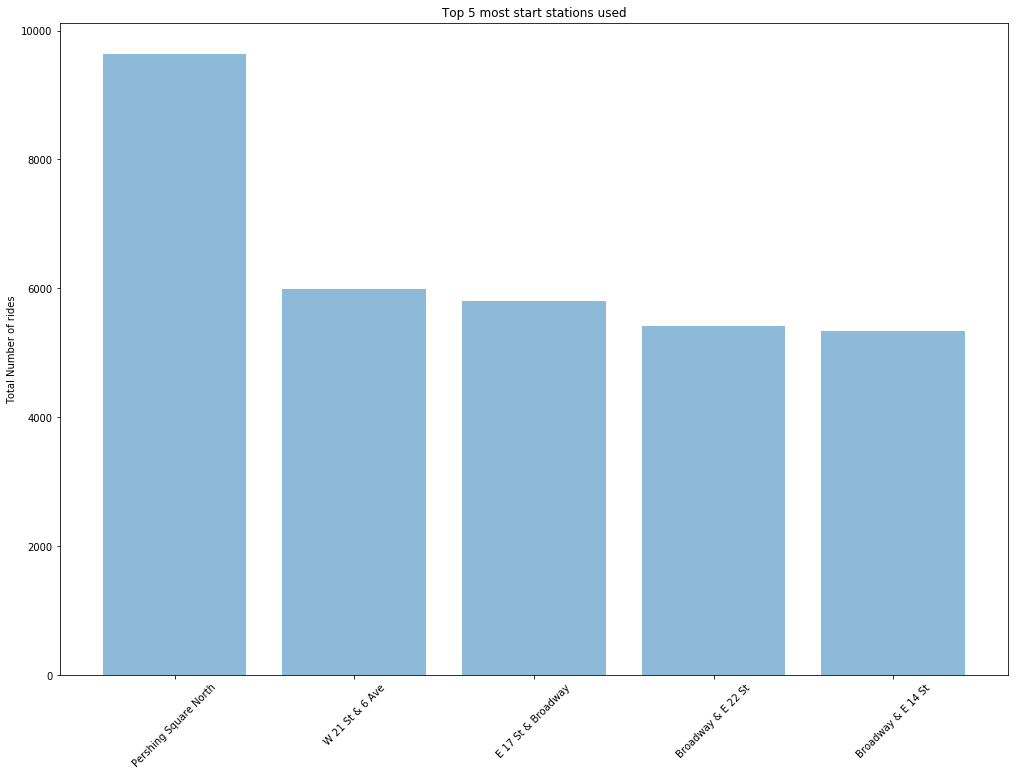

In [75]:
# get the top 5 most used stations as Start Stations
plt.figure(1, figsize=(17, 12))
y_pos=data['Start Station Name'].value_counts().head(5).values
x_values=data['Start Station Name'].value_counts().head(5).index.tolist()
x_pos = np.arange(len(x_values))
plt.bar(x_pos, y_pos, align='center', alpha=0.5)
plt.xticks(x_pos, x_values,rotation=45)
plt.ylabel('Total Number of rides')
plt.title('Top 5 most start stations used (Generated using pandas)')
plt.show()

In [76]:
#Get the number of rides during week ends and week days
plt.figure(1, figsize=(10, 7))
data['Week Day']=data['Start Time'].dt.to_period('d').dt.dayofweek<5
labels=data['Week Day'].value_counts().index.tolist()
xticks= ['Week Day' if x==True else 'Week End' for x in labels]
plt.pie(data['Week Day'].value_counts().values, labels=xticks,autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Number of rides during the weekdays and the weekends')
plt.show()

In [77]:
# Delete added column
data.drop('Week Day',axis=1,inplace=True)

In [78]:
# get the number of rides per day per gender(show only the first 4 days)
data.groupby([data['Start Time'].dt.to_period('d'),'Gender'])['Gender'].count().reset_index(name='count').sort_values(["Start Time","count"],ascending=True).head(12)

Start Time  Gender  count
0   2016-12-01       0   1675
2   2016-12-01       2   9350
1   2016-12-01       1  32217
3   2016-12-02       0   1905
5   2016-12-02       2   9161
4   2016-12-02       1  31305
6   2016-12-03       0   2722
8   2016-12-03       2   7301
7   2016-12-03       1  19831
9   2016-12-04       0   2922
11  2016-12-04       2   6610
10  2016-12-04       1  17923

## Save the cleaned dataset to cloud storage

In [79]:
data.to_csv("gs://foda-bucket/CitiBikeData.csv", index=False)